# DTSA 5509 Supervised Learning Final Project - Predicting Skipping Tracks

## Imports and configs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pylab as plt
from matplotlib import rcParams
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", 200)
pd.set_option("display.precision", 2)
sns.set_theme(style="ticks", palette="pastel")
rcParams['figure.figsize'] = 14,6

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 8


## Brief description of the problem and data

The goal of this project is to create an algorithm to predict when a user that is listening a song will skip the given track. A secondary goal is trying to identify what factors affect the listener's choice to skip a recommended track. To explore the factors that affect a user to skip a recommended track, I needed first to create the variable skipping_track. For me it was very intuitive to use listen_duration and track_duration to solve the problem. I am assuming that in general the amount of time the user spent listening to a track is a good proxy to how much the user liked the song. Therefore I divided the column listen_duration by track_duration to normalize the tracks regardless different durations and to have the distribution of listening duration percentage.

Analyzing this listening percentage distribution (Listening duration vs track duration) and reasoning about how long a user takes to decide if they like a song and if they will listen it until the end, I decided to considerate a recommended track being skipped if the user listens 30% or less of the track's duration. Taking in consideration only the Users that didn't reach the end of track, the threshold 30% seemed to be like an elbow in the cumulative distribution capturing a good candidate to be the point of decision in time.

In [2]:
raw_data = pd.read_json(
    path_or_buf = 'data.json', 
    orient = 'split', 
    convert_dates = ['ts', 'track_upload_date', 'listener_signup_date']
)

The dataset is composed by the fields below and **828169 rows**. The data comes from a music online platform. Each record represents the total amount of time the user spent listening to a track that had been recommended before a different track was played or the listening session ended. 

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828169 entries, 0 to 828168
Data columns (total 15 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   ts                                             828169 non-null  datetime64[ns]
 1   country_code                                   828169 non-null  object        
 2   client_version                                 828169 non-null  object        
 3   listening_context                              828169 non-null  object        
 4   recommender_algorithm_name                     828169 non-null  object        
 5   track_id                                       828169 non-null  object        
 6   track_genre_category                           828169 non-null  object        
 7   track_upload_date                              828169 non-null  datetime64[ns]
 8   track_duration                              

In [4]:
raw_data.head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened
0,2016-07-01 18:44:43,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,2016-06-23,413933,413933,0001d5755511cae40e5b32d83a3decce,2011-12-25,HipHop & R&B,6.17e+08,22.5
1,2016-07-01 18:48:44,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,2016-06-24,402640,110722,0001d5755511cae40e5b32d83a3decce,2011-12-25,HipHop & R&B,6.17e+08,22.5
2,2016-07-06 15:57:16,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,2016-06-28,494811,193818,0001d5755511cae40e5b32d83a3decce,2011-12-25,HipHop & R&B,6.17e+08,22.5
3,2016-07-01 19:39:11,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,2014-06-09,361585,361585,000264c5b34ad04999535c8b6a8b86e2,2013-09-17,HipHop & R&B,1.12e+08,10.5
4,2016-07-01 19:42:39,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,2015-11-28,373700,160162,000264c5b34ad04999535c8b6a8b86e2,2013-09-17,HipHop & R&B,1.12e+08,10.5


## Exploratory Data Analysis (EDA)

About Data handling and cleaning I basically treated missing values (using some simple imputation techniques as for example to bring the track duration for a given track that was zeroed using the track_id) and some weird values (applying basic logic rules as for example one cannot listen more time than the track duration).

Then I looked for relations between skipping_track and the other variables starting with the recommender algorithms because it is the source of the track recommendation as well the listening context and track genre. In addition to that I tried these combinations also using the variable listen_duration_by_track_duration to understand the differences in means between the groups drilling down this data also per track duration buckets.

### Missing values

In [5]:
raw_data.isnull().sum()

ts                                                   0
country_code                                         0
client_version                                       0
listening_context                                    0
recommender_algorithm_name                           0
track_id                                             0
track_genre_category                                 0
track_upload_date                                    0
track_duration                                       0
listen_duration                                      0
listener_id                                          0
listener_signup_date                                 0
listener_top_genre_category_listened              3777
listener_prev_month_listening_time               61608
listener_prev_month_avg_daily_tracks_listened    61608
dtype: int64

In [6]:
raw_data['listener_top_genre_category_listened'] = np.where(raw_data['listener_top_genre_category_listened'].isnull(), 
                                                                raw_data.groupby('listener_id')['track_genre_category'].transform(lambda x: x.value_counts().index[0]), 
                                                                raw_data['listener_top_genre_category_listened'])

raw_data.isnull().sum()

ts                                                   0
country_code                                         0
client_version                                       0
listening_context                                    0
recommender_algorithm_name                           0
track_id                                             0
track_genre_category                                 0
track_upload_date                                    0
track_duration                                       0
listen_duration                                      0
listener_id                                          0
listener_signup_date                                 0
listener_top_genre_category_listened                 0
listener_prev_month_listening_time               61608
listener_prev_month_avg_daily_tracks_listened    61608
dtype: int64

### Outliers

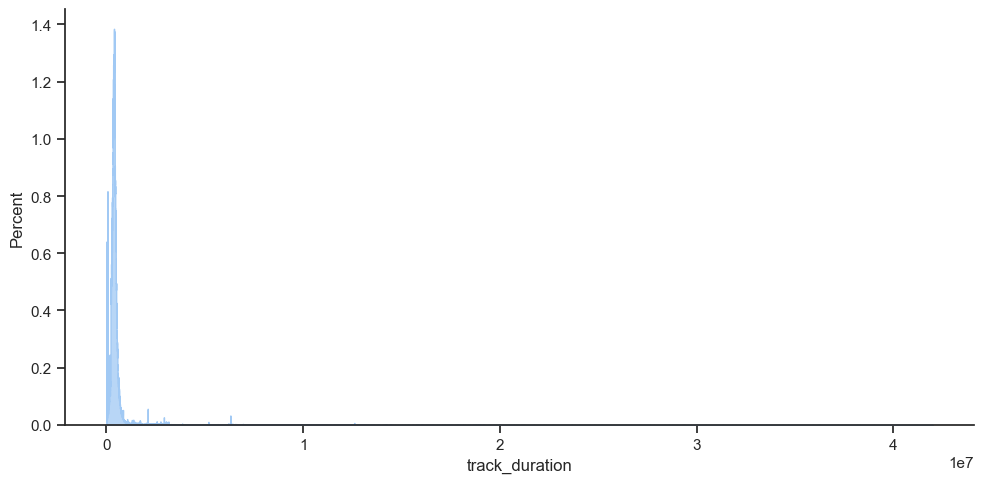

In [7]:
sns.displot(data=raw_data, x="track_duration", stat="percent", element="step", height=5, aspect=2, cumulative=False)

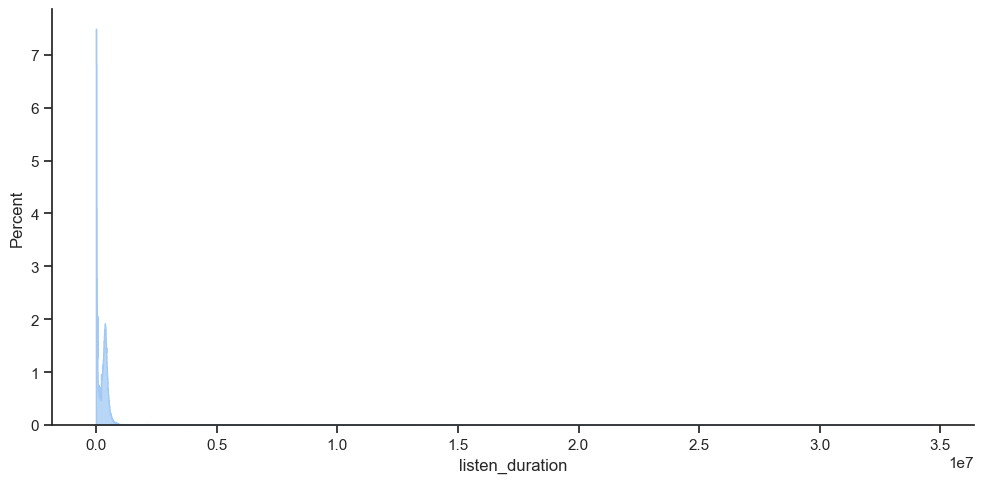

In [8]:
sns.displot(data=raw_data, x="listen_duration", stat="percent", element="step", height=5, aspect=2, cumulative=False)

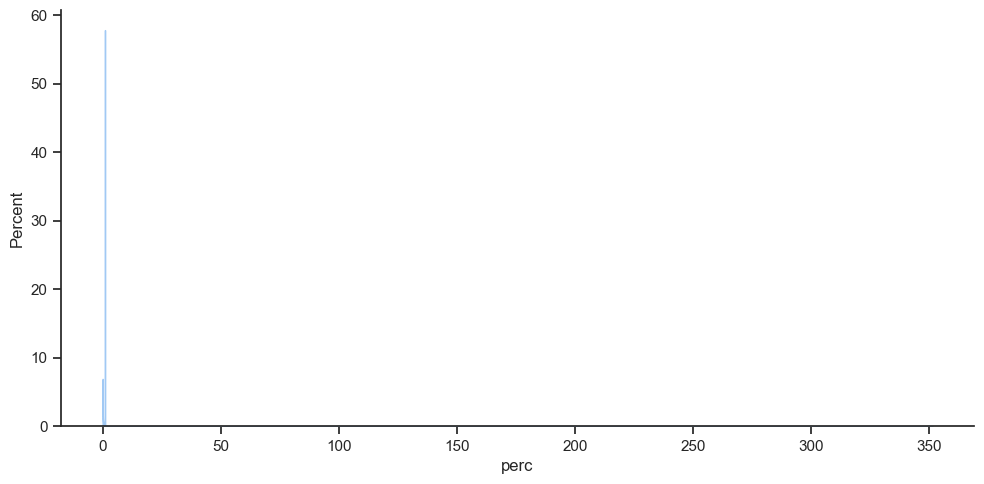

In [9]:
sns.displot(data=raw_data.assign(perc=raw_data['listen_duration']/raw_data['track_duration']), 
            x="perc", stat="percent", element="step", height=5, aspect=2)

In [10]:
raw_data['track_duration_corrected'] = np.where(raw_data['track_duration'] == 0, 
                                                    raw_data.groupby('track_id')['track_duration'].transform(lambda x: int(x.max())), 
                                                    raw_data['track_duration'])

raw_data['track_duration_corrected'] = np.where(raw_data['track_duration_corrected'] == 0, 
                                                    raw_data.groupby('track_genre_category')['track_duration_corrected'].transform(lambda x: int(x.median())), 
                                                    raw_data['track_duration_corrected'])

raw_data['listen_duration_corrected'] = np.where(raw_data['listen_duration'] < 0, 0, raw_data['listen_duration'])
raw_data['listen_duration_corrected'] = np.where(raw_data['listen_duration_corrected'] > raw_data['track_duration_corrected'], 
                                                     raw_data['track_duration_corrected'], raw_data['listen_duration_corrected'])

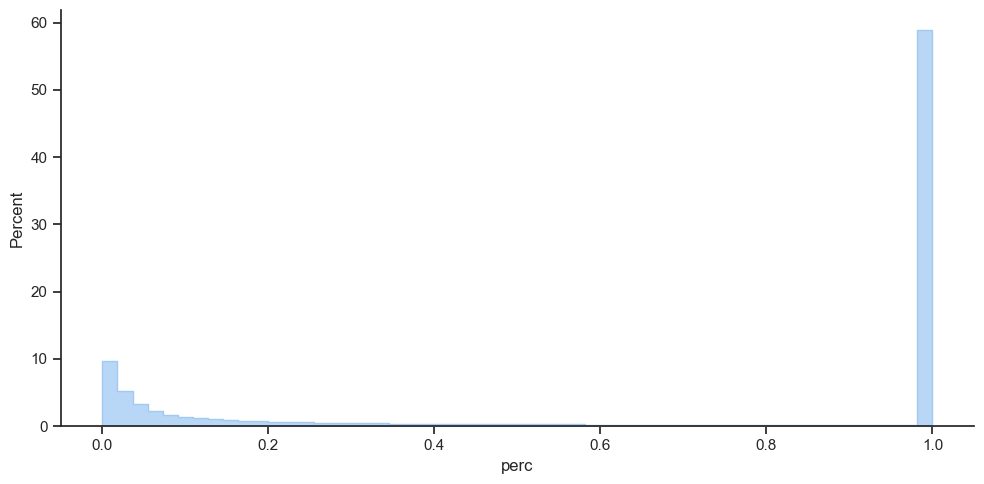

In [11]:
sns.displot(data=raw_data.assign(perc=raw_data['listen_duration_corrected']/raw_data['track_duration_corrected']), 
            x="perc", stat="percent", element="step", height=5, aspect=2)

### Feature engineering

In [12]:
raw_data[['client_version_p1', 'client_version_p2', 'client_version_p3']] = raw_data['client_version'].str.split('.', expand=True)

data = raw_data.assign(
    listener_prev_month_avg_daily_listening_time_hours = raw_data['listener_prev_month_listening_time']/1000/60/60/30,
    track_duration_minutes = raw_data['track_duration_corrected']/1000/60,
    listen_duration_minutes = raw_data['listen_duration_corrected']/1000/60,
    track_duration_minutes_bucket = pd.cut(raw_data['track_duration_corrected']/1000/60, bins=pd.IntervalIndex.from_tuples([(0, 4), (4, 10), (10, 750)])),
    listen_duration_by_track_duration = raw_data['listen_duration_corrected']/raw_data['track_duration_corrected'],
    months_since_upload = (raw_data['ts'] - raw_data['track_upload_date']).dt.days/30,
    years_since_signup = (raw_data['ts'] - raw_data['listener_signup_date']).dt.days/365,
    is_favorite_genre = raw_data['track_genre_category'] == raw_data['listener_top_genre_category_listened'],
    client_version_p1 = raw_data['client_version_p1'].astype(int),
    client_version_p2 = raw_data['client_version_p2'].astype(int),
    client_version_p3 = raw_data['client_version_p3'].astype(int),
    hour = raw_data['ts'].dt.hour,
    day = raw_data['ts'].dt.day,
    day_of_week = raw_data['ts'].dt.dayofweek,
    skipping_track = np.where(raw_data['listen_duration_corrected']/raw_data['track_duration_corrected'] <= 0.3, 1, 0)
).drop(
    columns = ['track_duration', 'track_duration_corrected', 'listen_duration', 'listen_duration_corrected', 
               'listener_prev_month_listening_time']
)

skipping_perc = data.skipping_track.mean()

data.describe(include='all')

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_avg_daily_tracks_listened,client_version_p1,client_version_p2,client_version_p3,listener_prev_month_avg_daily_listening_time_hours,track_duration_minutes,listen_duration_minutes,track_duration_minutes_bucket,listen_duration_by_track_duration,months_since_upload,years_since_signup,is_favorite_genre,hour,day,day_of_week,skipping_track
count,828169,828169,828169,828169,828169,828169,828169,828169,828169,828169,828169,766561.00,828169.00,828169.00,828169.00,766561.00,8.28e+05,828169.00,828169,828169.00,828169.00,828169.00,828169,828169.00,828169.00,828169.00,828169.00
unique,NaN,2,236,9,4,384470,13,NaN,58018,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,US,204.0.0,tracks,content-based,0826c48c8066710920765c742027d3d2,HipHop & R&B,NaN,0c5439d9e0faa9415c25893efb17e115,NaN,HipHop & R&B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(4, 10]",NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
freq,NaN,524770,419951,478340,737843,1191,439394,NaN,4809,NaN,544008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,651868,NaN,NaN,NaN,525369,NaN,NaN,NaN,NaN
mean,2016-07-11 18:44:07.683489536,NaN,NaN,NaN,NaN,NaN,NaN,2015-03-23 07:08:47.966151424,NaN,2014-03-26 00:10:51.414868480,NaN,45.73,180.23,0.45,4.84,73.58,8.74e+00,4.97,NaN,0.67,15.86,2.30,NaN,12.29,15.53,3.09,0.31
min,2016-06-26 00:39:36,NaN,NaN,NaN,NaN,NaN,NaN,2007-09-14 00:00:00,NaN,2007-12-02 00:00:00,NaN,1.50,0.00,0.00,0.00,0.00,1.48e-03,0.00,NaN,0.00,0.10,0.10,NaN,0.00,1.00,0.00,0.00
25%,2016-07-04 03:00:35,NaN,NaN,NaN,NaN,NaN,NaN,2014-07-02 00:00:00,NaN,2013-03-07 00:00:00,NaN,16.50,188.00,0.00,0.00,10.85,5.05e+00,0.70,NaN,0.13,2.67,0.94,NaN,5.00,8.00,1.00,0.00
50%,2016-07-11 16:02:17,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-03 00:00:00,NaN,2014-06-12 00:00:00,NaN,33.00,204.00,0.00,0.00,40.68,6.25e+00,4.67,NaN,1.00,10.40,2.08,NaN,14.00,16.00,3.00,0.00
75%,2016-07-19 10:38:02,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-21 00:00:00,NaN,2015-08-02 00:00:00,NaN,61.50,204.00,0.00,8.00,101.83,7.56e+00,6.58,NaN,1.00,24.67,3.35,NaN,19.00,23.00,5.00,1.00
max,2016-07-27 00:39:27,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-23 00:00:00,NaN,2016-05-22 00:00:00,NaN,637.50,2404.00,9428.00,360.00,1171.08,7.00e+02,577.57,NaN,1.00,107.57,8.62,NaN,23.00,30.00,6.00,1.00


### Data visualization

Text(0.5, 1.02, "Users that didn't reach the end of track")

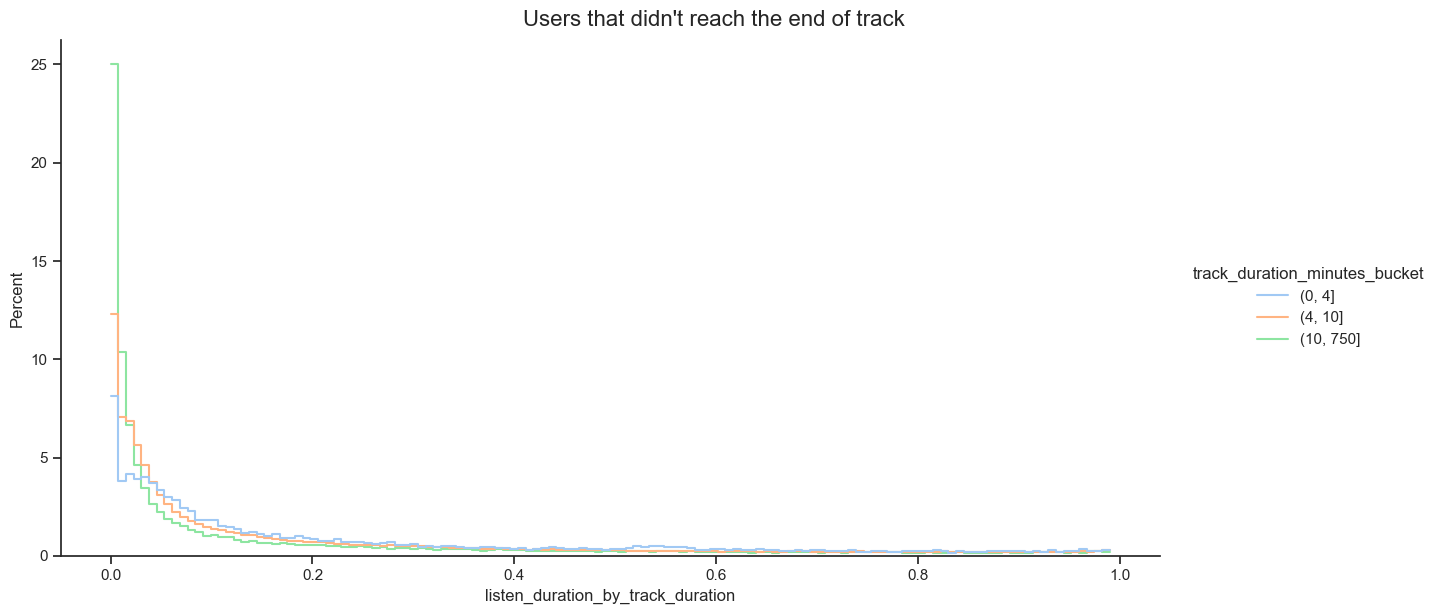

In [13]:
sns.displot(data=data[data['listen_duration_by_track_duration']<=0.99], x="listen_duration_by_track_duration", fill=False, hue='track_duration_minutes_bucket', common_norm=False, 
            stat="percent", element="step", height=6, aspect=2).fig.suptitle("Users that didn't reach the end of track", fontsize=16, y=1.02)

Text(0.5, 1.02, 'Means and intervals: listening duration percentage by recommender algorithm')

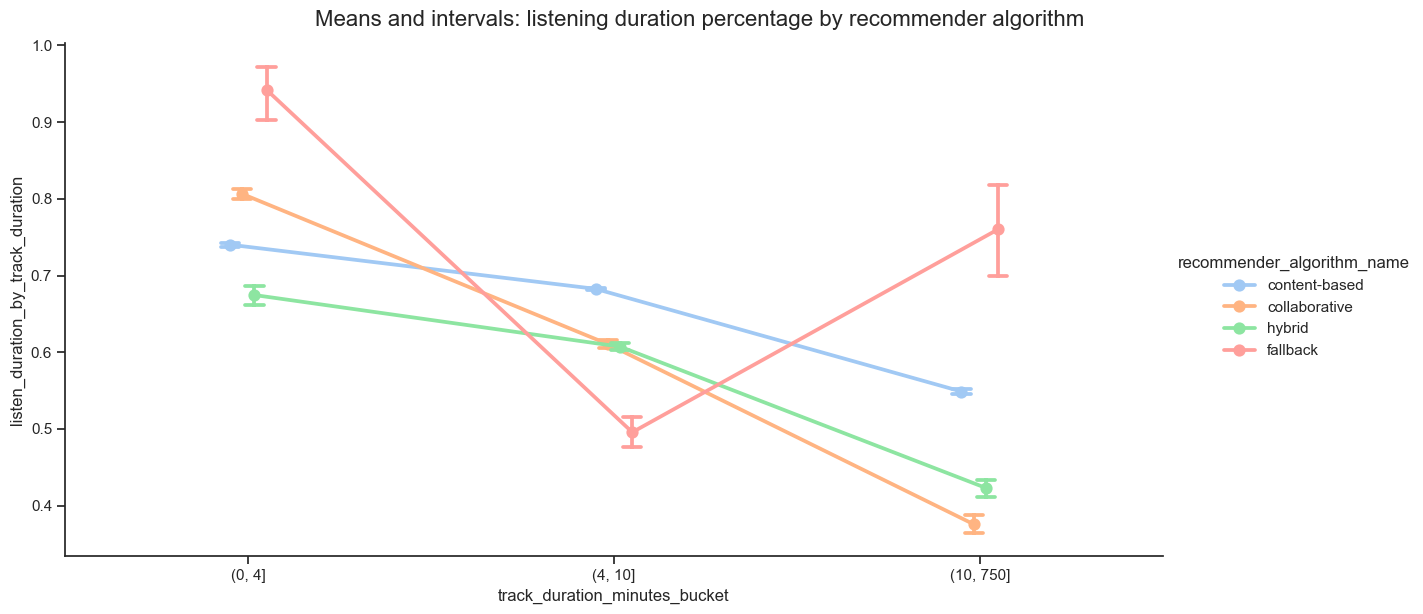

In [14]:
sns.catplot(x="track_duration_minutes_bucket", y="listen_duration_by_track_duration", hue="recommender_algorithm_name", capsize=0.05, dodge=True, kind="point",
            height=6, aspect=2, data=data).fig.suptitle("Means and intervals: listening duration percentage by recommender algorithm", fontsize=16, y=1.02)

Text(0.5, 1.02, 'Skipping track percentage by recommender algorithm')

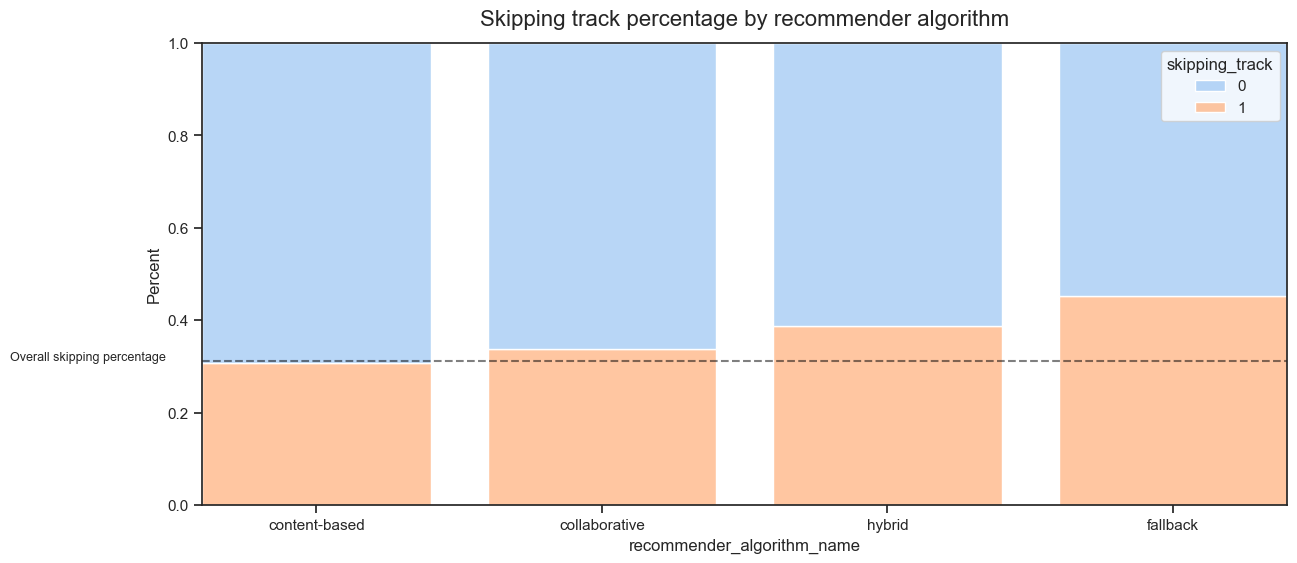

In [15]:
sns.histplot(data=data, x='recommender_algorithm_name', hue='skipping_track', stat='percent', multiple='fill', shrink=.8)
plt.axhline(skipping_perc, linewidth=1.5, linestyle='--', color='black', alpha=0.5)
plt.text(-0.8, skipping_perc, 'Overall skipping percentage', fontsize=9, ha='center')
plt.title("Skipping track percentage by recommender algorithm", fontsize=16, y=1.02)

Text(0.5, 1.02, 'Skipping track percentage by listening context')

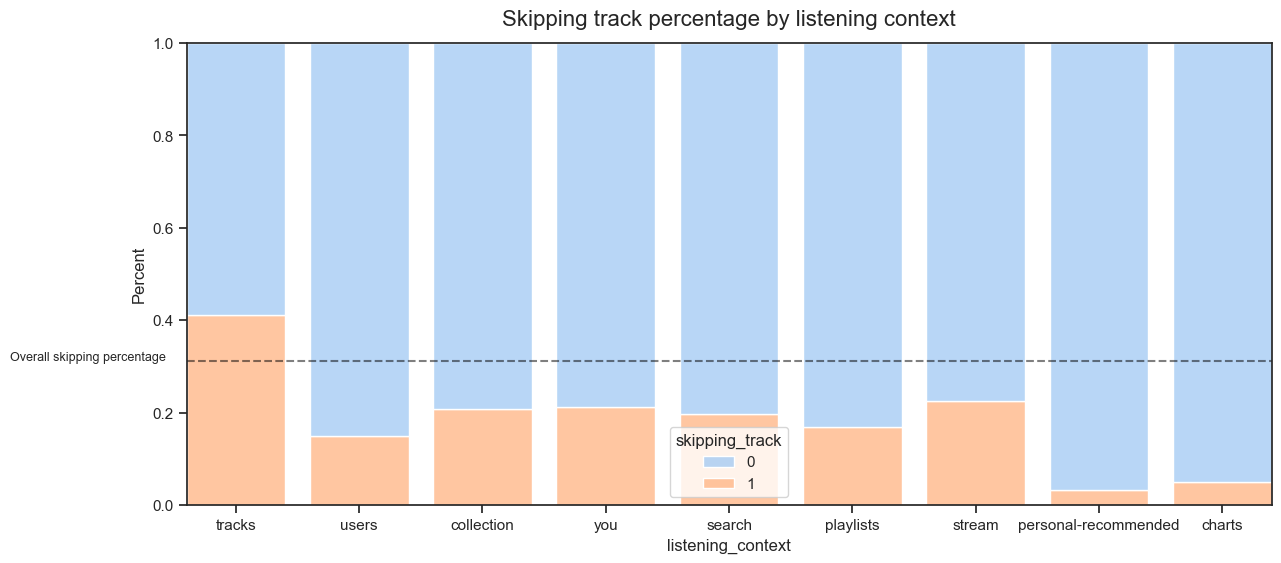

In [16]:
sns.histplot(data=data, x='listening_context', hue='skipping_track', stat='percent', multiple='fill', shrink=.8)
plt.axhline(skipping_perc, linewidth=1.5, linestyle='--', color='black', alpha=0.5)
plt.text(-1.2, skipping_perc, 'Overall skipping percentage', fontsize=9, ha='center')
plt.title("Skipping track percentage by listening context", fontsize=16, y=1.02)

Text(0.5, 1.02, 'Skipping track percentage by track genre')

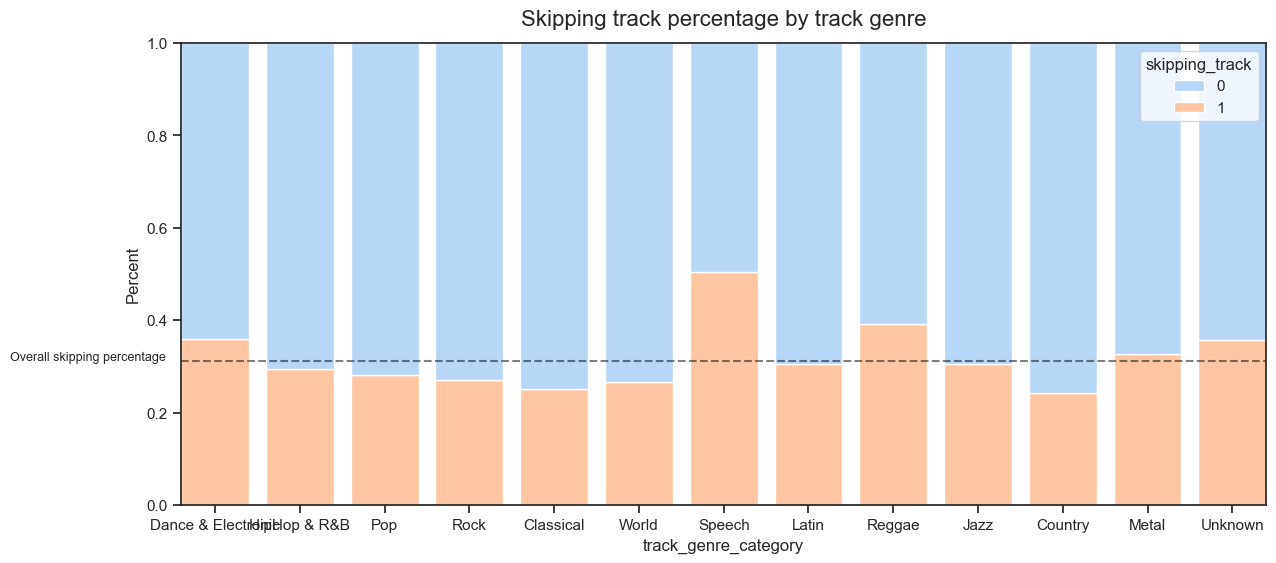

In [17]:
sns.histplot(data=data, x='track_genre_category', hue='skipping_track', stat='percent', multiple='fill', shrink=.8)
plt.axhline(skipping_perc, linewidth=1.5, linestyle='--', color='black', alpha=0.5)
plt.text(-1.5, skipping_perc, 'Overall skipping percentage', fontsize=9, ha='center')
plt.title("Skipping track percentage by track genre", fontsize=16, y=1.02)

## Model building and training

The initial idea to approach this problem was transforming the categorical variables into dummies to use them in the model as well. Then I started with a correlation matrix to investigate possible linear relations and after that I split the data into training and validation sets to create a grid with different machine learning models for classification problems and different parameters to select the best fit for the data based on cross validation.

In [18]:
df = pd.get_dummies(data[['recommender_algorithm_name','track_genre_category', 'hour', 'skipping_track', 'months_since_upload', 'listening_context', 'day_of_week',
                          'years_since_signup','is_favorite_genre','client_version_p1','client_version_p2','client_version_p3', 'track_duration_minutes']])

<Axes: >

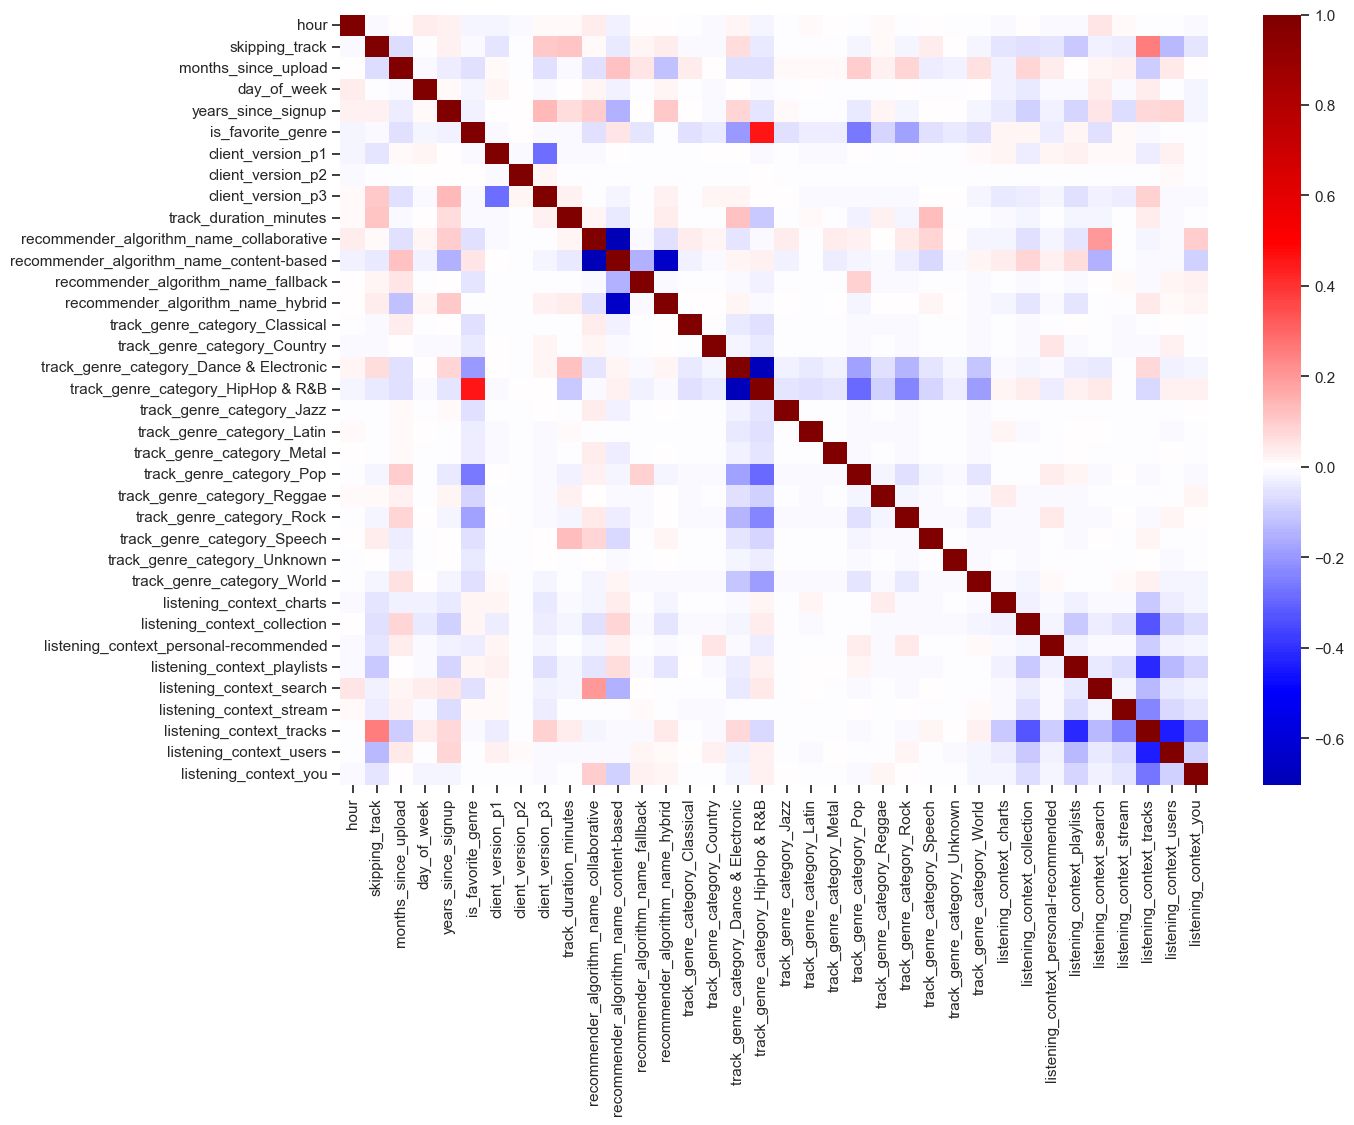

In [19]:
rcParams['figure.figsize'] = 14,10
sns.heatmap(df.corr(), annot=False, cmap = 'seismic', center=0)

In [20]:
X = df.drop(columns = 'skipping_track')
y = df.skipping_track

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=0)

### Comparison of models - Random Forest vs Gradient Boosted Trees

My idea was to use a tree based approach to try to find skipping levers. So I compared the classifiers Random Forest and Gradient Boosted Trees with a grid of parameters for depth of the tree and amount of estimators for RF and iterations for GB. I used 5 folds for cross validation with the training data and I used the area under the curve (AUC) to select the best model and parameters.

In [21]:
param_grid = [
    {
        'model': [RandomForestClassifier(class_weight = 'balanced')],
        'model__n_estimators': [100, 150, 200],
        'model__max_depth': [20, 25, 30]
    },
    {
        'model': [HistGradientBoostingClassifier(class_weight = 'balanced')],
        'model__max_iter': [300, 400, 500],
        'model__max_depth': [15, 20, 25]
    }
]

pipeline = Pipeline([('model', RandomForestClassifier())])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring = 'roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestClassifier(class_weight='balanced')],
                          'model__max_depth': [20, 25, 30],
                          'model__n_estimators': [100, 150, 200]},
                         {'model': [HistGradientBoostingClassifier(class_weight='balanced')],
                          'model__max_depth': [15, 20, 25],
                          'model__max_iter': [300, 400, 500]}],
             scoring='roc_auc', verbose=1)

#### Results (AUC) of the different models and parameters

In [22]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

print("AUC mean, AUC stdev, Params")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

AUC mean, AUC stdev, Params
0.805577 (0.000683) with: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 20, 'model__n_estimators': 100}
0.806803 (0.001125) with: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 20, 'model__n_estimators': 150}
0.807268 (0.000638) with: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 20, 'model__n_estimators': 200}
0.835616 (0.000836) with: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 25, 'model__n_estimators': 100}
0.836961 (0.000675) with: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 25, 'model__n_estimators': 150}
0.836886 (0.001119) with: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 25, 'model__n_estimators': 200}
0.852502 (0.000318) with: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 30, 'model__n_estimators': 100}
0.853085 (0.0

#### The best model 

In [23]:
print(f"Best model: {grid_search.best_params_}")
print(f"Best cross-validated AUC score: {grid_search.best_score_:.4f}")

Best model: {'model': RandomForestClassifier(class_weight='balanced'), 'model__max_depth': 30, 'model__n_estimators': 200}
Best cross-validated AUC score: 0.8536


In [41]:
model = RandomForestClassifier(class_weight='balanced', max_depth = 30, n_estimators= 200)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=200)

## Results

### Prediction with validation data

In [42]:
y_pred = model.predict_proba(X_test)[:,1]
y_true = y_test

### Best model metrics

In [43]:
print(classification_report(y_true, y_pred>0.5))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     56931
           1       0.66      0.67      0.67     25886

    accuracy                           0.79     82817
   macro avg       0.76      0.76      0.76     82817
weighted avg       0.79      0.79      0.79     82817



### Best model ROC curve

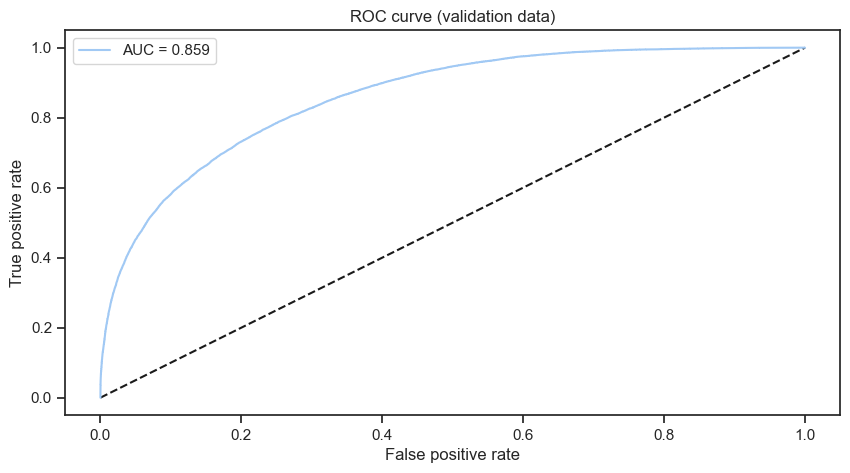

In [44]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
area_under_curve = auc(fpr, tpr)

rcParams['figure.figsize'] = 10,5
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve (validation data)")
plt.legend(loc="best")
plt.show()

### Best model confusion matrix

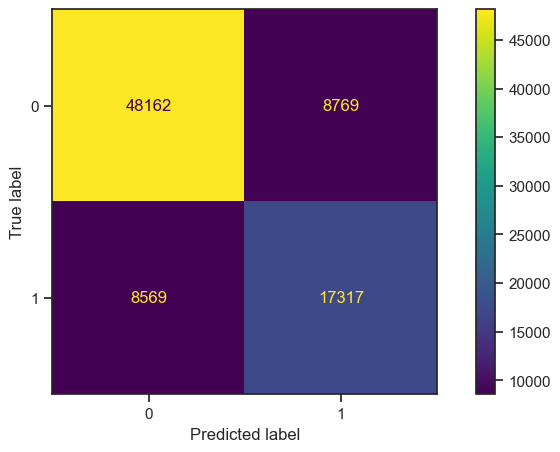

In [45]:
cm = confusion_matrix(y_test, y_pred>0.5)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Best model features importance

In [46]:
features_importance = pd.DataFrame({'feature': model.feature_names_in_,'feature_importance': model.feature_importances_})
features_importance.sort_values('feature_importance', ascending=False).head(10)

,feature,feature_importance
3,years_since_signup,0.21
8,track_duration_minutes,0.17
1,months_since_upload,0.16
0,hour,0.11
32,listening_context_tracks,0.07
2,day_of_week,0.07
5,client_version_p1,0.06
7,client_version_p3,0.03
33,listening_context_users,0.02
4,is_favorite_genre,0.02


## Conclusion

An interesting learning is that usually the Gradient Boosted Trees algorithm has a better performance against Random Forest however for this dataset the opposite happened even training with different parameters.

Something that didn't work well is that the best model output from GridSearchCV doesn't have the features importance within the object. So I had to train the model again with the best parameters.

As next steps or things to improve, maybe defining the target in a different way and training the model again. Like for example if the listener stops listening the track before 30 seconds this could be considered a skip. Maybe this would be a better approach regardless the duration of the tracks.

Other things I could do is keep trying to optimize the hyperparameters for the best model selected, but for this dataset was very expensive in terms of computer resources.